In [1]:
%load_ext autoreload
%autoreload 2

# Introduction 

Change the instantiation of user features into random instead

# Imports

In [2]:
import pandas as pd
import numpy as np
import torch

from utils.setup_nodes import create_edge_lists
from utils.graph_helpers import train_model, plot_train_val_loss, final_evaluation, plot_activation_heatmap_and_density
from utils.graph_model import Base_GNN_Model
from utils.general import seed_everything
from utils.predictions import recommend_products, pretty_print_recomendations, get_top_k_preds

# Set up

In [3]:
seed_everything()

In [4]:
user_split = "train_test_valid"
prod_embed_name = "title_features_512"
user_embed_name = "user_reviews_features_512"

data_dir = "data"
product_dir = "full_data"
embedding_dir = "embedding"

device = "cuda"

product_cols = ["parent_asin", "average_rating", "rating_number"]
user_cols = ["user_id", "rating_mean", "rating_count", "helpful_vote_mean", "helpful_vote_gte_1", "verified_purchase_mean", "last_active_in_days_min",
            "last_active_in_days_max", "word_count_mean"]
edge_cols = ["user_id", "parent_asin", "rating"]

fill_users = "zero"

# Load data

In [5]:
product_df = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = product_cols)
train_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/train_agg.parquet", columns = user_cols)
train_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/train.parquet", columns = edge_cols)

if user_split == "train_test_valid":
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/valid_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/valid.parquet", columns = edge_cols)
else:
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/test_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/test.parquet", columns = edge_cols)


In [6]:
product_embedding = torch.load(f"{data_dir}/{embedding_dir}/product/{prod_embed_name}.pt")
train_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/train_{user_embed_name}.pt")
if user_split == "train_test_valid":
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/valid_{user_embed_name}.pt")
else:
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/test_{user_embed_name}.pt")

# Make nodes

In [7]:
# Add the embedding 
train_user_df["embedding"] = list(train_user_embedding.numpy())
test_user_df["embedding"] = list(test_user_embedding.numpy())

# Concat user nodes 
additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()

## these are users that need to be zero-ed out 
additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()
additional_test_users["embedding"] = list(torch.zeros((len(additional_test_users), test_user_embedding.shape[1])).numpy())
if fill_users == "zero":
    additional_test_users.iloc[:, 1:-1] = 0
elif fill_users == "mean":
    additional_test_users.iloc[:, 1:-1] = train_user_df.iloc[:, 1:].mean()

# Make super user df
user_df = pd.concat([train_user_df, additional_test_users])

In [8]:
# Set up id mapping
offset = user_df.user_id.nunique()
user_id_to_idx = {unique_id : idx for idx, unique_id in enumerate(user_df.user_id.unique())}
prod_id_to_idx = {unique_id : offset + idx for idx, unique_id in enumerate(product_df.parent_asin.unique())}

# Add to df
product_df["prod_idx"] = product_df.parent_asin.apply(lambda x: prod_id_to_idx[x])
train_user_edges["user_idx"] = train_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
test_user_edges["user_idx"] = test_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
train_user_edges["prod_idx"] = train_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])
test_user_edges["prod_idx"] = test_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])

In [9]:
# Concat product nodes 
product_nodes = torch.cat([torch.tensor(product_df.drop(["parent_asin", "prod_idx"], axis = 1).to_numpy()), product_embedding], dim = 1)

In [10]:
# concat user nodes 
user_embed = torch.tensor(np.vstack(user_df["embedding"].values))
user_info = torch.tensor(user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
user_nodes = torch.cat([user_info, user_embed], dim = 1)

user_nodes = torch.rand(user_nodes.shape)

In [ ]:
# Create edge list
train_edge_index, train_edge_weights = create_edge_lists(train_user_edges)
test_edge_index, test_edge_weights = create_edge_lists(train_user_edges)

# Move to GPU 

In [12]:
product_nodes = product_nodes.type(torch.float).to(device)
user_nodes = user_nodes.type(torch.float).to(device)
train_edge_index = train_edge_index.to(device)
train_edge_weights = train_edge_weights.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_weights = test_edge_weights.to(device)

# Model

In [13]:
# Set up model features
num_users = len(user_df)
num_products = len(product_df)
user_feature_dim = user_nodes.shape[1]
product_feature_dim = product_nodes.shape[1]
embedding_dim = 64

In [14]:
# Instantiate the model
model = Base_GNN_Model(num_users, num_products, user_feature_dim, product_feature_dim, embedding_dim)

In [15]:
# move the model 
model.to(device)

Base_GNN_Model(
  (user_embedding): Embedding(383703, 64)
  (product_embedding): Embedding(89060, 64)
  (user_feature_transform): Linear(in_features=776, out_features=64, bias=True)
  (product_feature_transform): Linear(in_features=770, out_features=64, bias=True)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

# Add hook 

This will help track the outputs

In [16]:
# Record activations for visualization
activations = {}  # Dictionary to store activations
def hook_fn(module, input, output):
    """Hook function to capture activations."""
    activations[module] = output
model.conv1.register_forward_hook(hook_fn)
model.conv2.register_forward_hook(hook_fn)
model.user_feature_transform.register_forward_hook(hook_fn)
model.product_feature_transform.register_forward_hook(hook_fn)

# Train

In [17]:
train_loss, test_loss, best_model = train_model(model, train_edge_index, train_edge_weights, test_edge_index, test_edge_weights, 
                                                 user_nodes, product_nodes, num_epochs = 1000, print_progress=True, print_freq=100)

Epoch: 100, Train Loss: 2.3480, Val Loss: 2.4977, best model epoch: 79
Epoch: 200, Train Loss: 1.7362, Val Loss: 2.5267, best model epoch: 79
Epoch: 300, Train Loss: 0.7853, Val Loss: 2.5521, best model epoch: 79
Epoch: 400, Train Loss: 0.6020, Val Loss: 2.7529, best model epoch: 79
Epoch: 500, Train Loss: 4.0149, Val Loss: 5.0055, best model epoch: 79
Epoch: 600, Train Loss: 0.7755, Val Loss: 2.8425, best model epoch: 79
Epoch: 700, Train Loss: 0.5413, Val Loss: 3.1127, best model epoch: 79
Epoch: 800, Train Loss: 0.3600, Val Loss: 3.1780, best model epoch: 79
Epoch: 900, Train Loss: 0.2616, Val Loss: 3.1983, best model epoch: 79
Epoch: 1000, Train Loss: 0.1846, Val Loss: 3.2735, best model epoch: 79


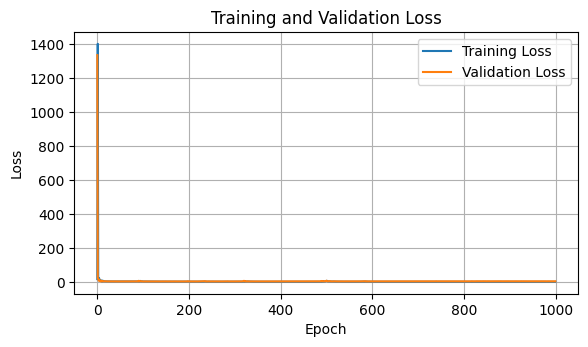

In [18]:
plot_train_val_loss(train_loss, test_loss)

# Test

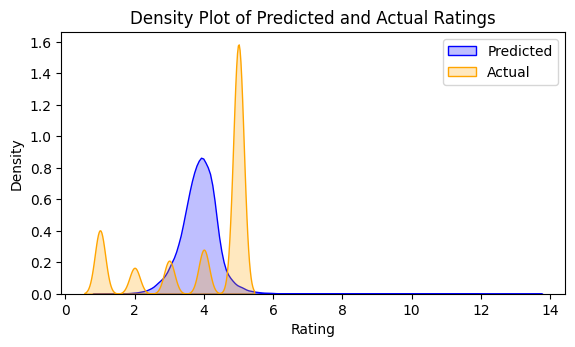

Test loss: 2.3603


In [19]:
model.load_state_dict(best_model)
final_evaluation(model, test_edge_index, test_edge_weights, user_nodes, product_nodes, device, True)

# Recomendations 

In [20]:
title_mapping = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = ["parent_asin", "title"])
prod_idx_to_id = {idx - offset: asin for asin, idx in prod_id_to_idx.items()}

In [21]:
# The pure random 
user_id = test_user_df.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: Alaska Fishing: DVD & Ultimate Guide! Lake Creek King Salmon Float Trip
Product 2: Tranquility Products 5lb Kaolin Clay Powder
Product 3: Upsweep Extra Grip Silver 500 Count 5X11 Hair Foils Color Processing Sheets, Aluminum Foils with Pop-Up Box for Highlighting and Balayage, Reinforced Thickness of Foil Sheets with no Mangles
Product 4: Runnin' the Line: Dirt and Water Trapping Basics ~ Hunting DVD Coyote Coon More
Product 5: 100% Organic Virgin Argan Oil of Morocco, Cold Pressed, Unrefined, Hexane Free for Face, Body, Skin, Hair and Nails, Anti Aging Moisturizer, Dry Scalp, Split Ends, Stretch Marks for Men and Women
Product 6: Disposable Lip Brushes 600 Pcs Make Up Brush Lipstick Lip Gloss Wands Applicator Tool(Rose,600 pcs)
Product 7: YuanKanJu Back Country Naturals Emu Oil 4 oz Unscented
Product 8: Body by LA MER The Rejuvenating Hand Serum 48ml
Product 9: Vera Wang Sheer Veil By Vera Wang For Women. Shimmering Bath And Shower Gel 5-Ounce
Product 10: [SOOMIAN] Korean Co

In [22]:
# The user with some data 
existing_test_users = test_user_df[test_user_df.user_id.isin(train_user_df.user_id)].copy()[["user_id"]]

In [23]:
user_id = existing_test_users.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: Alaska Fishing: DVD & Ultimate Guide! Lake Creek King Salmon Float Trip
Product 2: Tranquility Products 5lb Kaolin Clay Powder
Product 3: Upsweep Extra Grip Silver 500 Count 5X11 Hair Foils Color Processing Sheets, Aluminum Foils with Pop-Up Box for Highlighting and Balayage, Reinforced Thickness of Foil Sheets with no Mangles
Product 4: Runnin' the Line: Dirt and Water Trapping Basics ~ Hunting DVD Coyote Coon More
Product 5: 100% Organic Virgin Argan Oil of Morocco, Cold Pressed, Unrefined, Hexane Free for Face, Body, Skin, Hair and Nails, Anti Aging Moisturizer, Dry Scalp, Split Ends, Stretch Marks for Men and Women
Product 6: Disposable Lip Brushes 600 Pcs Make Up Brush Lipstick Lip Gloss Wands Applicator Tool(Rose,600 pcs)
Product 7: YuanKanJu Back Country Naturals Emu Oil 4 oz Unscented
Product 8: Body by LA MER The Rejuvenating Hand Serum 48ml
Product 9: Vera Wang Sheer Veil By Vera Wang For Women. Shimmering Bath And Shower Gel 5-Ounce
Product 10: [SOOMIAN] Korean Co

In [24]:
# The boosted way
# This is just to see if existing data (a bit of data leak) can help improve performance 
boosted_additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()
boosted_user_df = pd.concat([train_user_df, boosted_additional_test_users])
boosted_user_embed = torch.tensor(np.vstack(boosted_user_df["embedding"].values))
boosted_user_info = torch.tensor(boosted_user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
boosted_user_nodes = torch.cat([boosted_user_embed, boosted_user_info], dim = 1)

In [25]:
user_id = boosted_user_df.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: Alaska Fishing: DVD & Ultimate Guide! Lake Creek King Salmon Float Trip
Product 2: Tranquility Products 5lb Kaolin Clay Powder
Product 3: Upsweep Extra Grip Silver 500 Count 5X11 Hair Foils Color Processing Sheets, Aluminum Foils with Pop-Up Box for Highlighting and Balayage, Reinforced Thickness of Foil Sheets with no Mangles
Product 4: Runnin' the Line: Dirt and Water Trapping Basics ~ Hunting DVD Coyote Coon More
Product 5: 100% Organic Virgin Argan Oil of Morocco, Cold Pressed, Unrefined, Hexane Free for Face, Body, Skin, Hair and Nails, Anti Aging Moisturizer, Dry Scalp, Split Ends, Stretch Marks for Men and Women
Product 6: Disposable Lip Brushes 600 Pcs Make Up Brush Lipstick Lip Gloss Wands Applicator Tool(Rose,600 pcs)
Product 7: YuanKanJu Back Country Naturals Emu Oil 4 oz Unscented
Product 8: Body by LA MER The Rejuvenating Hand Serum 48ml
Product 9: Vera Wang Sheer Veil By Vera Wang For Women. Shimmering Bath And Shower Gel 5-Ounce
Product 10: [SOOMIAN] Korean Co

In [26]:
# count more than 10 purchases
min_unique_purchase = 10
item_count_df = test_user_edges.groupby("user_id").prod_idx.apply(lambda x: len(set(x))).reset_index()
dense_user_id = item_count_df[item_count_df["prod_idx"] >= min_unique_purchase][["user_id"]]

In [27]:
user_id = dense_user_id.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: Alaska Fishing: DVD & Ultimate Guide! Lake Creek King Salmon Float Trip
Product 2: Tranquility Products 5lb Kaolin Clay Powder
Product 3: Upsweep Extra Grip Silver 500 Count 5X11 Hair Foils Color Processing Sheets, Aluminum Foils with Pop-Up Box for Highlighting and Balayage, Reinforced Thickness of Foil Sheets with no Mangles
Product 4: Runnin' the Line: Dirt and Water Trapping Basics ~ Hunting DVD Coyote Coon More
Product 5: 100% Organic Virgin Argan Oil of Morocco, Cold Pressed, Unrefined, Hexane Free for Face, Body, Skin, Hair and Nails, Anti Aging Moisturizer, Dry Scalp, Split Ends, Stretch Marks for Men and Women
Product 6: Disposable Lip Brushes 600 Pcs Make Up Brush Lipstick Lip Gloss Wands Applicator Tool(Rose,600 pcs)
Product 7: YuanKanJu Back Country Naturals Emu Oil 4 oz Unscented
Product 8: Body by LA MER The Rejuvenating Hand Serum 48ml
Product 9: Vera Wang Sheer Veil By Vera Wang For Women. Shimmering Bath And Shower Gel 5-Ounce
Product 10: [SOOMIAN] Korean Co

# Analysing predictions


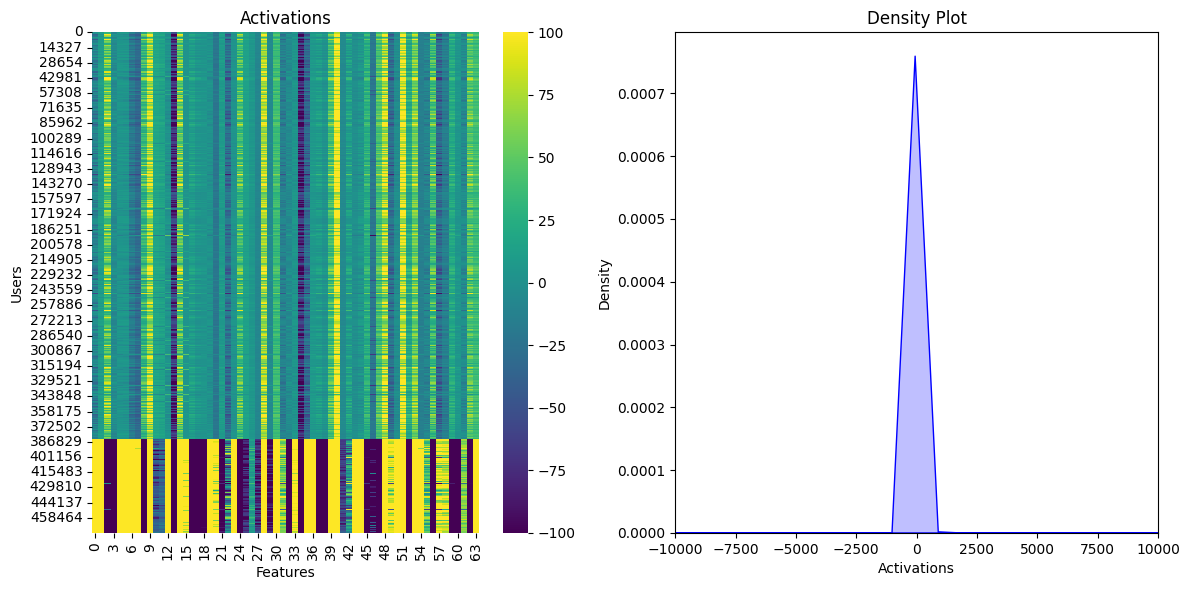

In [28]:
# Visualize activations of conv2 activation output
activations_of_interest = activations[model.conv2].detach().cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

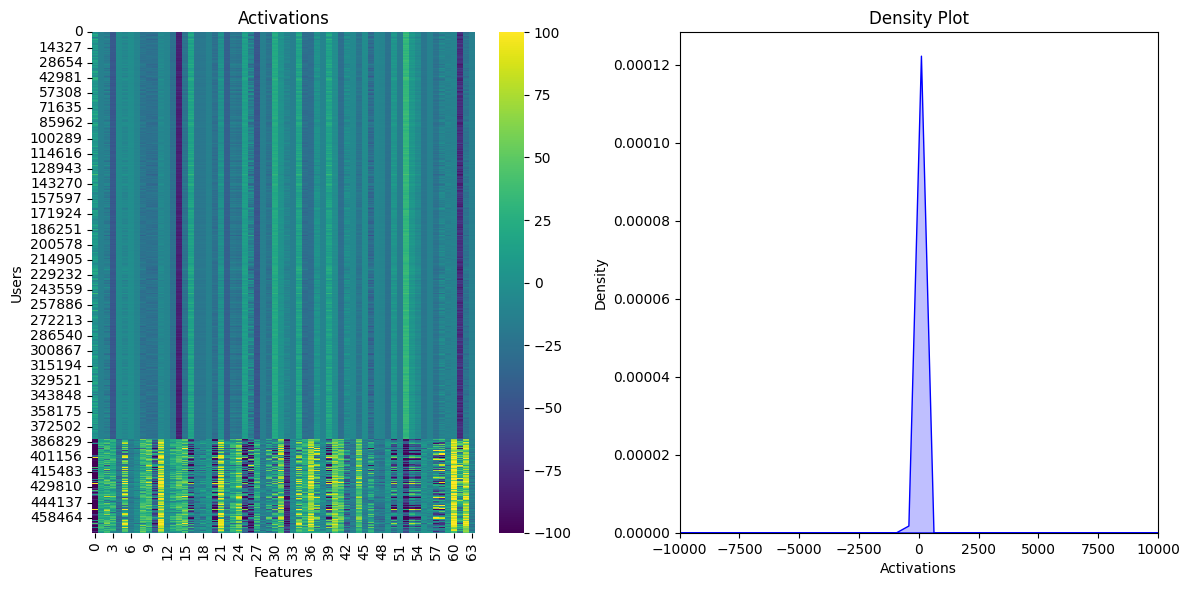

In [29]:
# Visualize activations of conv1 activation output
activations_of_interest = activations[model.conv1].detach().cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

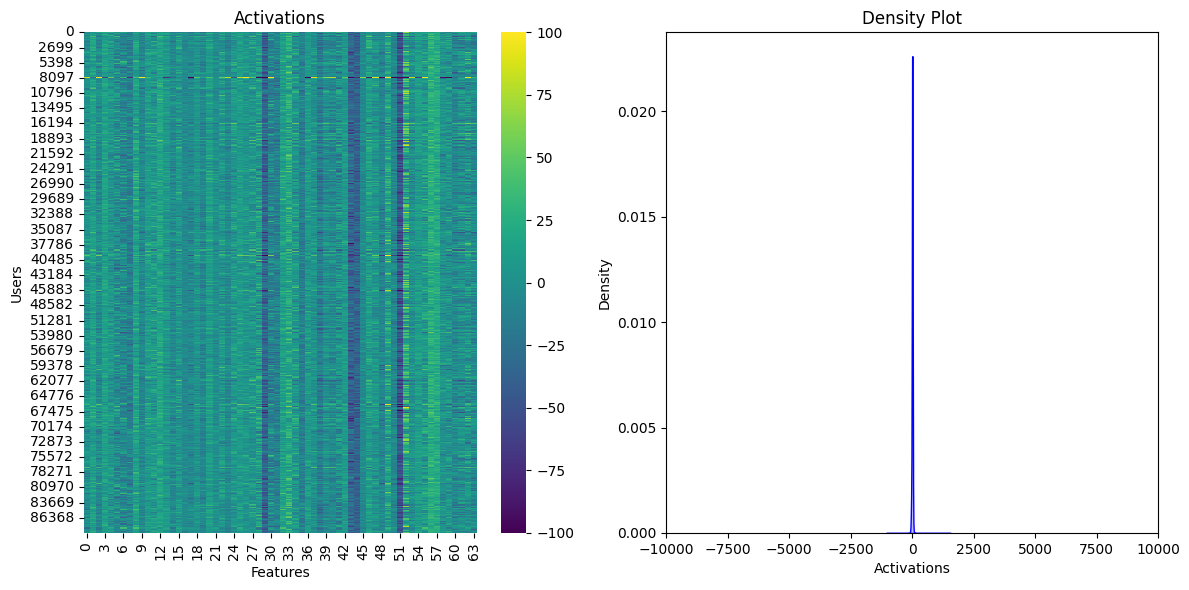

In [30]:
# Visualize activations of product_feature_transform activation output
activations_of_interest = activations[model.product_feature_transform].cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

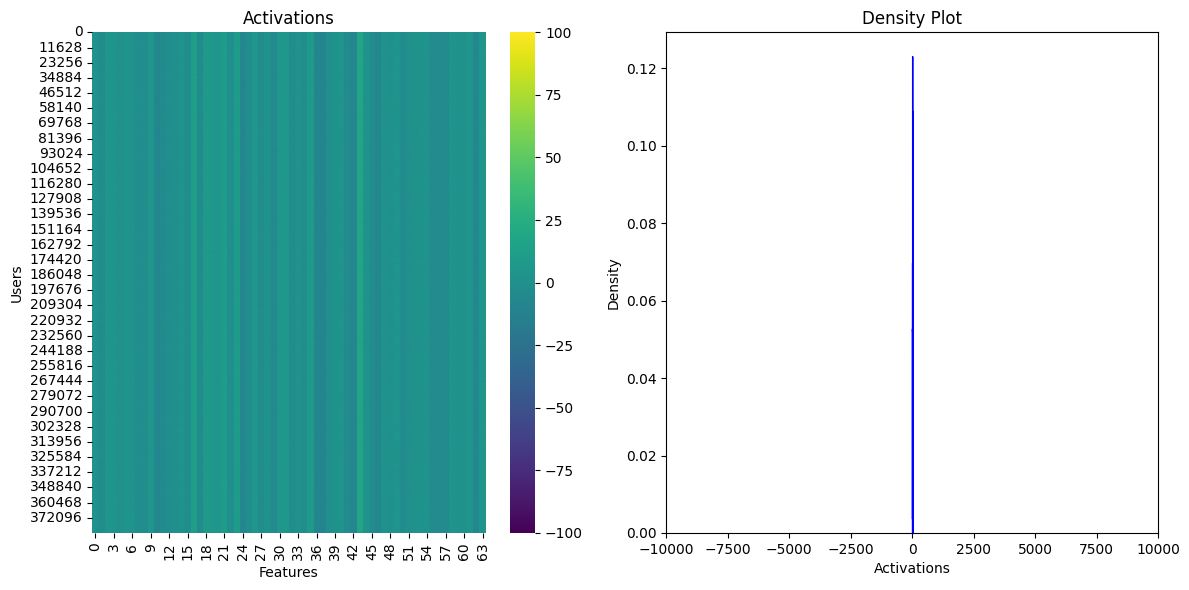

In [31]:

# Visualize activations of user_feature_transform activation output
activations_of_interest = activations[model.user_feature_transform].cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)